In [1]:
import pandas as pd
import numpy as np

# 데이터 로드
orders = pd.read_csv('data/orders.csv')
order_products = pd.read_csv('data/order_products__prior.csv')
products = pd.read_csv('data/products.csv')
aisles = pd.read_csv('data/aisles.csv')
departments = pd.read_csv('data/departments.csv')

In [2]:
# 고객별 주문 횟수 계산
user_order_counts = orders.groupby('user_id').size()

# 상위 20% 고객 선택
top_users = user_order_counts[user_order_counts >= user_order_counts.quantile(0.8)].index

# 필터링 적용
orders = orders[orders['user_id'].isin(top_users)]

In [3]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
160,1737705,17,prior,1,2,13,NaN
161,1681401,17,prior,2,5,10,3.0
162,2680214,17,prior,3,3,10,5.0
163,3197376,17,prior,4,1,14,5.0
164,3237467,17,prior,5,6,17,5.0


In [5]:
# 상품별 주문 횟수 계산
product_order_counts = order_products.groupby('product_id').size()

# 상위 20% 상품 선택
top_products = product_order_counts[product_order_counts >= product_order_counts.quantile(0.8)].index

# 필터링 적용
order_products = order_products[order_products['product_id'].isin(top_products)]

In [13]:
product_order_counts.reset_index()

,product_id,0
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15
...,...,...
49672,49684,9
49673,49685,49
49674,49686,120
49675,49687,13


In [9]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
# 주문 정보와 상품 주문 정보 병합
order_details = pd.merge(order_products, orders[['order_id', 'user_id', 'order_number', 'order_dow', 'order_hour_of_day']], 
                         on='order_id', how='inner')

# 상품 정보 병합
order_details = pd.merge(order_details, products[['product_id', 'product_name', 'aisle_id', 'department_id']], 
                         on='product_id', how='inner')

# 상품의 카테고리 정보 병합
order_details = pd.merge(order_details, aisles[['aisle_id', 'aisle']], on='aisle_id', how='left')
order_details = pd.merge(order_details, departments[['department_id', 'department']], on='department_id', how='left')

print(order_details.shape)  # 데이터 크기 확인

(12360734, 13)


In [8]:
order_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,product_name,aisle_id,department_id,aisle,department
0,3,33754,1,1,205970,16,5,17,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs
1,342,33754,11,1,183968,24,2,17,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs
2,582,33754,18,0,193223,6,2,19,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs
3,1171,33754,32,1,100330,20,1,13,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs
4,1502,33754,1,0,175768,13,0,14,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs


In [7]:
# 데이터 타입 최적화
order_details['order_id'] = order_details['order_id'].astype('int32')
order_details['product_id'] = order_details['product_id'].astype('int32')
order_details['user_id'] = order_details['user_id'].astype('int32')
order_details['aisle_id'] = order_details['aisle_id'].astype('int16')
order_details['department_id'] = order_details['department_id'].astype('int16')
order_details['reordered'] = order_details['reordered'].astype('int8')

print(order_details.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12360734 entries, 0 to 12360733
Data columns (total 13 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   order_id           int32 
 1   product_id         int32 
 2   add_to_cart_order  int64 
 3   reordered          int8  
 4   user_id            int32 
 5   order_number       int64 
 6   order_dow          int64 
 7   order_hour_of_day  int64 
 8   product_name       object
 9   aisle_id           int16 
 10  department_id      int16 
 11  aisle              object
 12  department         object
dtypes: int16(2), int32(3), int64(4), int8(1), object(3)
memory usage: 954.8+ MB
None


In [8]:
# 고객별 구매 패턴
user_features = order_details.groupby('user_id').agg(
    user_total_orders=('order_number', 'max'),
    user_total_products=('product_id', 'count'),
    user_reorder_rate=('reordered', 'mean'),
    user_avg_cart_size=('add_to_cart_order', 'mean')
).reset_index()

In [12]:
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42498 entries, 0 to 42497
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              42498 non-null  int64  
 1   user_total_orders    42498 non-null  int64  
 2   user_total_products  42498 non-null  int64  
 3   user_reorder_rate    42498 non-null  float64
 4   user_avg_cart_size   42498 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 1.6 MB


In [9]:
user_features.head()

,user_id,user_total_orders,user_total_products,user_reorder_rate,user_avg_cart_size
0,17,40,108,0.861111,2.814815
1,21,33,127,0.543307,4.708661
2,27,81,500,0.782000,7.478000
3,28,24,154,0.480519,5.870130
4,36,34,44,0.636364,3.181818


In [10]:
# 상품별 구매 패턴
product_features = order_details.groupby('product_id').agg(
    product_total_orders=('order_id', 'count'),
    product_reorder_rate=('reordered', 'mean'),
    product_avg_add_to_cart=('add_to_cart_order', 'mean')
).reset_index()
product_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_id               1989 non-null   int64  
 1   product_total_orders     1989 non-null   int64  
 2   product_reorder_rate     1989 non-null   float64
 3   product_avg_add_to_cart  1989 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 62.3 KB


In [11]:
product_features.head()

,product_id,product_total_orders,product_reorder_rate,product_avg_add_to_cart
0,34,3466,0.702827,9.365840
1,45,10759,0.755089,8.162376
2,79,2065,0.625182,10.785956
3,116,2693,0.797623,5.831415
4,117,2410,0.880913,6.830290


In [12]:
# 고객-상품 조합 정보
user_product_features = order_details.groupby(['user_id', 'product_id']).agg(
    user_product_orders=('order_id', 'count'),
    user_product_reorder_rate=('reordered', 'mean')
).reset_index()
user_product_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3144502 entries, 0 to 3144501
Data columns (total 4 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   user_id                    int64  
 1   product_id                 int64  
 2   user_product_orders        int64  
 3   user_product_reorder_rate  float64
dtypes: float64(1), int64(3)
memory usage: 96.0 MB


In [20]:
user_product_features.head()

,user_id,product_id,user_product_orders,user_product_reorder_rate
0,17,812,1,0.0
1,17,1073,2,0.5
2,17,1774,5,0.8
3,17,4591,1,0.0
4,17,5077,1,0.0


In [13]:
# 고객-상품 조합에 고객 정보 병합
final_data = pd.merge(user_product_features, user_features, on='user_id', how='left')

# 고객-상품 조합에 상품 정보 병합
final_data = pd.merge(final_data, product_features, on='product_id', how='left')

print(final_data.shape)  # 데이터 크기 확인

(3144502, 11)


In [14]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3144502 entries, 0 to 3144501
Data columns (total 11 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   user_id                    int64  
 1   product_id                 int64  
 2   user_product_orders        int64  
 3   user_product_reorder_rate  float64
 4   user_total_orders          int64  
 5   user_total_products        int64  
 6   user_reorder_rate          float64
 7   user_avg_cart_size         float64
 8   product_total_orders       int64  
 9   product_reorder_rate       float64
 10  product_avg_add_to_cart    float64
dtypes: float64(5), int64(6)
memory usage: 287.9 MB


In [15]:
final_data.head()

,user_id,product_id,user_product_orders,user_product_reorder_rate,user_total_orders,user_total_products,user_reorder_rate,user_avg_cart_size,product_total_orders,product_reorder_rate,product_avg_add_to_cart
0,17,812,1,0.000000,40,108,0.861111,2.814815,2197,0.613564,10.868457
1,17,5077,1,0.000000,40,108,0.861111,2.814815,34572,0.848693,7.009430
2,17,7350,33,0.969697,40,108,0.861111,2.814815,2093,0.833254,6.275681
3,17,9387,4,0.750000,40,108,0.861111,2.814815,20471,0.766890,7.381711
4,17,16797,10,0.900000,40,108,0.861111,2.814815,77908,0.807748,7.220568


In [16]:
final_data = final_data.drop(['user_total_orders', 'product_total_orders', 'user_product_orders'], axis=1)

In [17]:
final_data.head()

,user_id,product_id,user_product_reorder_rate,user_total_products,user_reorder_rate,user_avg_cart_size,product_reorder_rate,product_avg_add_to_cart
0,17,812,0.000000,108,0.861111,2.814815,0.613564,10.868457
1,17,5077,0.000000,108,0.861111,2.814815,0.848693,7.009430
2,17,7350,0.969697,108,0.861111,2.814815,0.833254,6.275681
3,17,9387,0.750000,108,0.861111,2.814815,0.766890,7.381711
4,17,16797,0.900000,108,0.861111,2.814815,0.807748,7.220568


In [24]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4788994 entries, 0 to 4788993
Data columns (total 8 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   user_id                    int64  
 1   product_id                 int64  
 2   user_product_reorder_rate  float64
 3   user_total_products        int64  
 4   user_reorder_rate          float64
 5   user_avg_cart_size         float64
 6   product_reorder_rate       float64
 7   product_avg_add_to_cart    float64
dtypes: float64(5), int64(3)
memory usage: 328.8 MB


In [19]:
# 불필요한 구매를 정의하는 기준 (재구매 확률이 0.6 이하인 경우)
threshold = 0.6

# 'target' 컬럼 생성: 재구매 확률이 0.6 이하 -> 0 (불필요), 0.6 이상 -> 1 (필요)
final_data['target'] = final_data['user_product_reorder_rate'].apply(lambda x: 1 if x >= threshold else 0)

# 종속변수 확인
final_data[['user_id', 'product_id', 'user_product_reorder_rate', 'target']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3144502 entries, 0 to 3144501
Data columns (total 4 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   user_id                    int64  
 1   product_id                 int64  
 2   user_product_reorder_rate  float64
 3   target                     int64  
dtypes: float64(1), int64(3)
memory usage: 120.0 MB


In [85]:
final_data[['user_id', 'product_id', 'user_product_reorder_rate', 'target']].head()

,user_id,product_id,user_product_reorder_rate,target
0,17,812,0.0,0
1,17,1073,0.5,0
2,17,1774,0.8,1
3,17,4591,0.0,0
4,17,5077,0.0,0


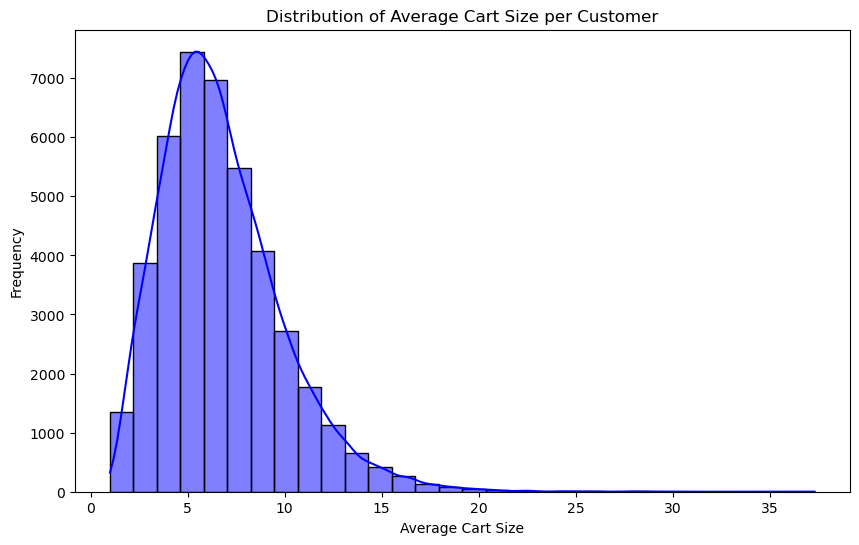

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# 고객별 평균 장바구니 크기 계산
user_avg_cart_size = order_details.groupby('user_id')['add_to_cart_order'].mean()

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
sns.histplot(user_avg_cart_size, bins=30, kde=True, color='blue')
plt.title('Distribution of Average Cart Size per Customer')
plt.xlabel('Average Cart Size')
plt.ylabel('Frequency')
plt.show()

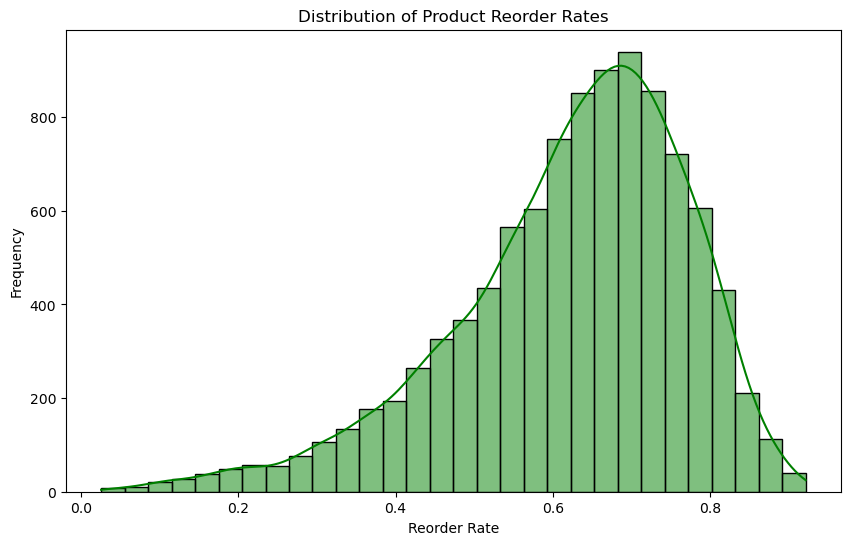

In [28]:
# 상품별 재구매율 계산
product_reorder_rate = order_details.groupby('product_id')['reordered'].mean()

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
sns.histplot(product_reorder_rate, bins=30, kde=True, color='green')
plt.title('Distribution of Product Reorder Rates')
plt.xlabel('Reorder Rate')
plt.ylabel('Frequency')
plt.show()

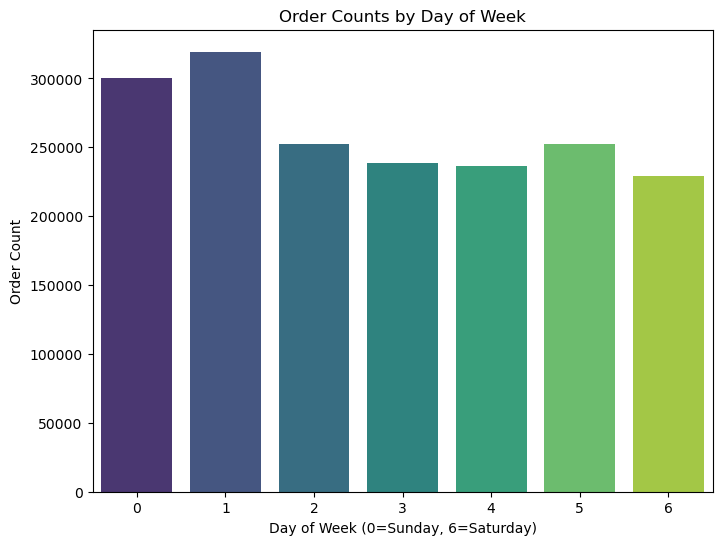

In [29]:
# 요일별 주문량 계산
order_dow_counts = orders['order_dow'].value_counts().sort_index()

# 막대그래프 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x=order_dow_counts.index, y=order_dow_counts.values, palette='viridis')
plt.title('Order Counts by Day of Week')
plt.xlabel('Day of Week (0=Sunday, 6=Saturday)')
plt.ylabel('Order Count')
plt.show()

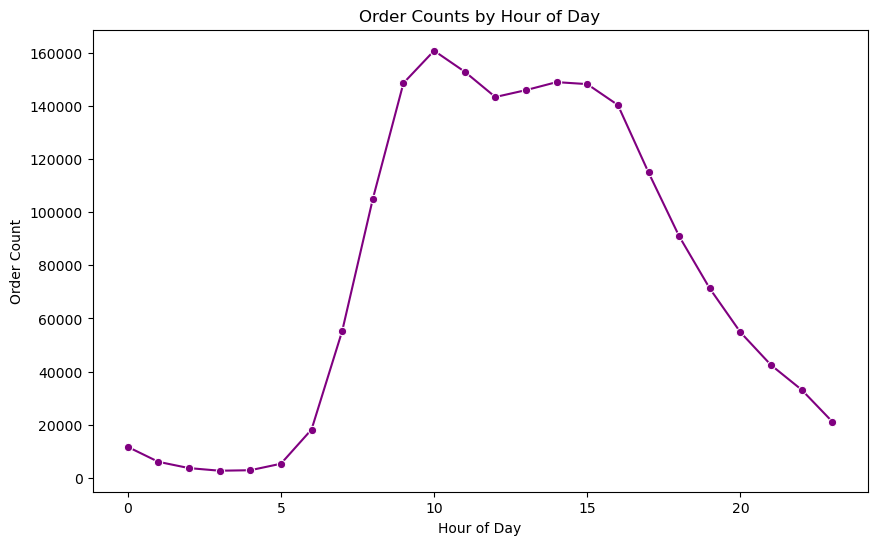

In [30]:
# 시간대별 주문량 계산
order_hour_counts = orders['order_hour_of_day'].value_counts().sort_index()

# 선 그래프 시각화
plt.figure(figsize=(10, 6))
sns.lineplot(x=order_hour_counts.index, y=order_hour_counts.values, marker='o', color='purple')
plt.title('Order Counts by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Order Count')
plt.show()

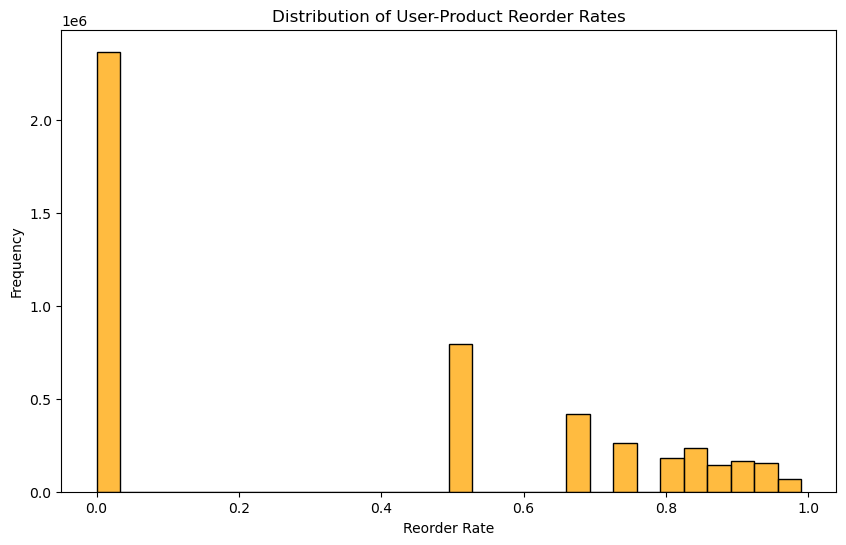

In [33]:
# 고객-상품 조합별 재구매율 계산
user_product_reorder_rate = user_product_features['user_product_reorder_rate']

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
sns.histplot(user_product_reorder_rate, bins=30, color='orange')
plt.title('Distribution of User-Product Reorder Rates')
plt.xlabel('Reorder Rate')
plt.ylabel('Frequency')
plt.show()

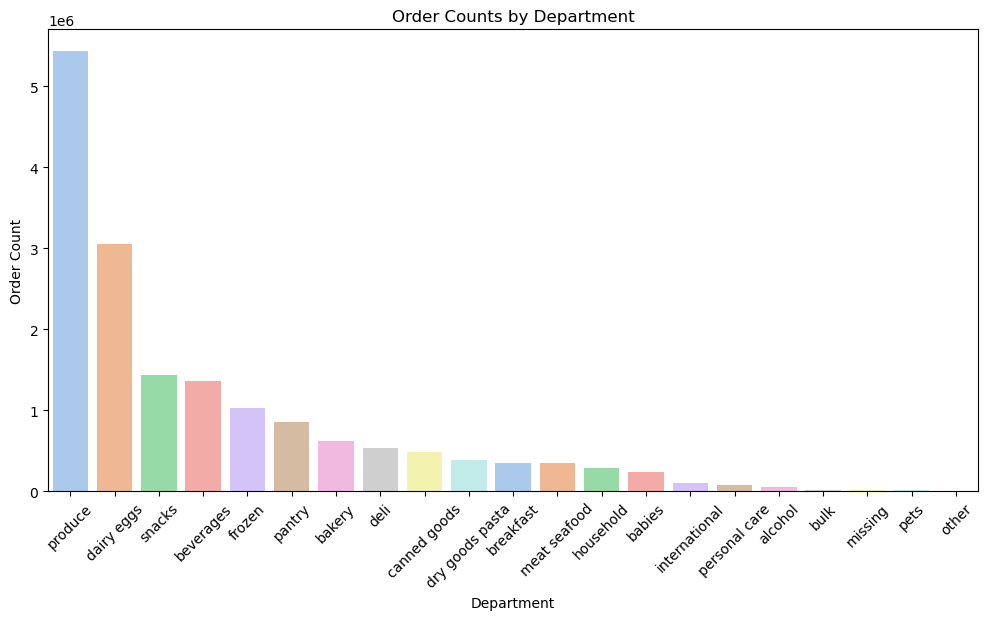

In [35]:
# 부서별 주문량 계산
department_order_counts = order_details['department'].value_counts()

# 막대그래프 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=department_order_counts.index, y=department_order_counts.values, palette='pastel')
plt.title('Order Counts by Department')
plt.xticks(rotation=45)
plt.xlabel('Department')
plt.ylabel('Order Count')
plt.show()

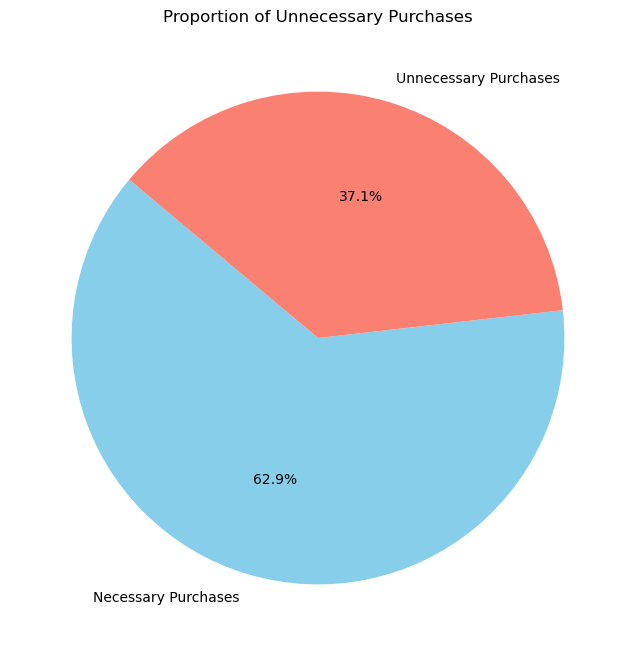

In [88]:
# 상품별 재구매율 기준으로 불필요 구매 분류
threshold = 0.6  # 재구매율이 60% 미만인 경우를 불필요 구매로 정의
product_reorder_rate = order_details.groupby('product_id')['reordered'].mean()
unnecessary_purchase_rate = (product_reorder_rate < threshold).mean()

# Pie 차트로 비율 시각화
labels = ['Necessary Purchases', 'Unnecessary Purchases']
sizes = [1 - unnecessary_purchase_rate, unnecessary_purchase_rate]
colors = ['skyblue', 'salmon']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Unnecessary Purchases')
plt.show()

In [22]:
import numpy as np
from tensorflow.keras.models import Sequential  # 모델 생성
from tensorflow.keras.layers import Dense, Input, Dropout

In [23]:
# 최종 데이터 셋에서 user_id, product_id 컬럼 제거
final_data_ind = final_data.drop(['user_id', 'product_id'], axis=1)
final_data_ind.head()

,user_product_reorder_rate,user_total_products,user_reorder_rate,user_avg_cart_size,product_reorder_rate,product_avg_add_to_cart,target
0,0.000000,108,0.861111,2.814815,0.613564,10.868457,0
1,0.000000,108,0.861111,2.814815,0.848693,7.009430,0
2,0.969697,108,0.861111,2.814815,0.833254,6.275681,1
3,0.750000,108,0.861111,2.814815,0.766890,7.381711,1
4,0.900000,108,0.861111,2.814815,0.807748,7.220568,1


In [24]:
from sklearn.model_selection import train_test_split

# 10% 샘플링 (층화 샘플링)
sampled_data, _ = train_test_split(
    final_data_ind, 
    test_size=0.9,  # 전체 데이터의 90%를 제외
    stratify=final_data['target'],  # 종속변수 기준으로 층화
    random_state=42
)

print("샘플링 후 데이터 크기:", sampled_data.shape)

샘플링 후 데이터 크기: (314450, 7)


In [25]:
sampled_data.to_csv('data/sampled_data.csv')

In [27]:
# 독립변수 정규화 스케일링
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(sampled_data.iloc[:, :-1])

X_scaled.shape

(314450, 6)

In [28]:
print(X_scaled[:5])

[[0.         0.20871143 0.8329443  0.10554463 0.85673883 0.48087034]
 [0.7578125  0.24936479 0.82069836 0.17358574 0.67569577 0.78592506]
 [0.84201389 0.02395644 0.63700414 0.05995906 0.94077525 0.07016417]
 [0.909375   0.18656987 0.8778399  0.14695437 0.76028027 0.61129398]
 [0.         0.17313975 0.79005179 0.20706153 0.69610594 0.7981973 ]]


In [29]:
# 종속변수 분리(target)
y = sampled_data.iloc[:,-1]
y.shape

(314450,)

In [30]:
# 훈련, 테스트 데이터셋 분류
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((251560, 6), (62890, 6), (251560,), (62890,))

In [31]:
# DNN모델 설계
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'), 
    Dropout(0.3),                                             
    Dense(32, activation='relu'),                            
    Dropout(0.3),                                             
    Dense(16, activation='relu'),                             
    Dense(1, activation='sigmoid')                            
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,073
Trainable params: 3,073
Non-trainabl

In [32]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=20, 
                    batch_size=128, 
                    verbose=1)

Epoch 1/20
1966/1966 [==============================] - 5s 2ms/step - loss: 0.0329 - accuracy: 0.9890 - val_loss: 3.9056e-05 - val_accuracy: 1.0000
Epoch 2/20
1966/1966 [==============================] - 4s 2ms/step - loss: 3.3007e-04 - accuracy: 0.9999 - val_loss: 2.0582e-06 - val_accuracy: 1.0000
Epoch 3/20
1966/1966 [==============================] - 4s 2ms/step - loss: 2.2268e-04 - accuracy: 0.9999 - val_loss: 2.9989e-07 - val_accuracy: 1.0000
Epoch 4/20
1966/1966 [==============================] - 4s 2ms/step - loss: 1.0973e-04 - accuracy: 1.0000 - val_loss: 2.9307e-07 - val_accuracy: 1.0000
Epoch 5/20
1966/1966 [==============================] - 4s 2ms/step - loss: 1.4595e-05 - accuracy: 1.0000 - val_loss: 1.2548e-08 - val_accuracy: 1.0000
Epoch 6/20
1966/1966 [==============================] - 4s 2ms/step - loss: 2.0422e-04 - accuracy: 0.9999 - val_loss: 1.4220e-07 - val_accuracy: 1.0000
Epoch 7/20
1966/1966 [==============================] - 4s 2ms/step - loss: 1.7523e-05 - acc

In [82]:
order_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,product_name,aisle_id,department_id,aisle,department
0,3,33754,1,1,205970,16,5,17,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs
1,342,33754,11,1,183968,24,2,17,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs
2,582,33754,18,0,193223,6,2,19,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs
3,1171,33754,32,1,100330,20,1,13,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs
4,1502,33754,1,0,175768,13,0,14,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs


In [83]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
160,1737705,17,prior,1,2,13,NaN
161,1681401,17,prior,2,5,10,3.0
162,2680214,17,prior,3,3,10,5.0
163,3197376,17,prior,4,1,14,5.0
164,3237467,17,prior,5,6,17,5.0


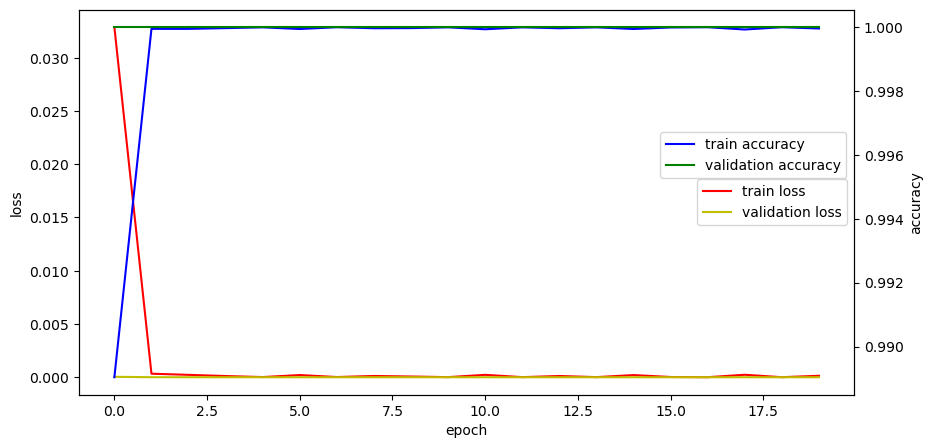

In [35]:
import matplotlib.pyplot as plt

# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(history.history['loss'], 'r', label='train loss')
loss_ax.plot(history.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(history.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [36]:
# 모델 평가
model.evaluate(X_test, y_test)

1966/1966 [==============================] - 2s 1ms/step - loss: 1.7474e-08 - accuracy: 1.0000


[1.747397071483192e-08, 1.0]

In [21]:
import requests

client_id = "T3xJlimKqJrEwhcK6VTd"
client_secret = "uqGAxFqUDv"
headers = {
    "X-Naver-Client-Id": client_id,
    "X-Naver-Client-Secret": client_secret
}

query = "유기농 식품"
url = f"https://openapi.naver.com/v1/search/news.json?query={query}&display=100&sort=date"
response = requests.get(url, headers=headers)
data = response.json()

# 데이터 확인
for item in data['items']:
    print(item['title'], item['link'])

NS홈쇼핑, 한상차림 간편하게 '설 <b>식품</b> 집중편성' https://n.news.naver.com/mnews/article/014/0005296096?sid=101
강진 믿음영농, 건강과 맛을 담은 ‘누룽지칩&amp;버섯스낵’ 출시 https://www.viva100.com/article/20250115501037
[기획] 급식업계, 줄어드는 학생보다 늘어나는 시니어 공략 http://www.m-i.kr/news/articleView.html?idxno=1199452
골든벨통상, <b>유기농</b> NFC 레몬즙 스틱형 출시 https://www.dailysecu.com/news/articleView.html?idxno=163012
[오늘의 제약리뷰] 유유제약‧JW중외제약‧동아제약‧동국제약 http://www.financialreview.co.kr/news/articleView.html?idxno=32631
강진 믿음영농, 건강과 맛 담은 '누룽지칩&amp;버섯스낵' 출시 http://www.welfarenews.net/news/articleView.html?idxno=107269
NS홈쇼핑, 설 연휴 대비 <b>식품</b> 특별 편성 https://www.healthinnews.co.kr/view.php?ud=202501151206073607204ead0791_48
[단독] &quot;맥주처럼 마시자&quot;…이마트, G7 캔와인 '세계 최초' 출시 https://n.news.naver.com/mnews/article/015/0005082521?sid=101
[이BIO] 동국제약·한미사이언스·차병원 외 http://www.newsprime.co.kr/news/article.html?no=671134
산엔청쇼핑몰, 설 명절 맞이 기획전 마련 https://www.newsgn.com/news/articleView.html?idxno=461018
NS홈쇼핑, '긴 연휴' 대비 명절 먹거리 방송 집중 편성 https://www.ziksir.com/new

In [42]:
reordered_products = order_products.groupby('product_id')['reordered'].mean()

In [44]:
products_real = pd.merge(reordered_products, products, on='product_id', how='left')

In [56]:
products_real_real = products_real[products_real['reordered'] > 0.6]

In [57]:
pd.merge(departments, products_real_real, on='department_id', how='left')

,department_id,department,product_id,reordered,product_name,aisle_id
0,1,frozen,130.0,0.620083,Vanilla Milk Chocolate Almond Ice Cream Bars M...,37.0
1,1,frozen,162.0,0.691807,Organic Mini Homestyle Waffles,52.0
2,1,frozen,1398.0,0.708058,Ice Bag,37.0
3,1,frozen,2326.0,0.668617,Organic Blueberry Waffles,52.0
4,1,frozen,2452.0,0.634391,Naturals Chicken Nuggets,129.0
...,...,...,...,...,...,...
1031,20,deli,40396.0,0.660356,Guacamole,67.0
1032,20,deli,41588.0,0.616879,Firm Tofu,14.0
1033,20,deli,42585.0,0.663611,Organic Extra Firm Tofu,14.0
1034,20,deli,45788.0,0.618570,Garlic Lovers Hommus,67.0


In [52]:
departments

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk
